In [2]:
import glob
import pylab as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetching image depth data 

In this notebook, we will explore basic localization from image depth maps. In overhead depth images, the pixel value represents the distance between each pixel and the camera plane: yellow shades are far from the sensor and, the darker the pixel color, the closer the pixel is to the sensor. Heads are, therefore, in darker shade than the floor. 

As usual, we leverage on the `sociophysicsDataHandler` to download the data from the TU/e research drive.

In [ ]:
from sociophysicsDataHandler import SociophysicsDataHandler

# initialize the data handler
dh = SociophysicsDataHandler()

# fetch depth map data
dh.fetch_depth_data_from_path(path = 'depth_kinect_glow17/17.11.11-15-53-28_2017-11-11_20-25-41.262248_9d6c8ecc-8253-4578-9714-1691ba5596cd_00000264_475993.tar.json.gz')

# for convenience, save the data in variables
depth_maps = dh.dd
time = dh.t

trying to fetch: /ProRail_USE_LL_data/depth_kinect_glow17/17.11.11-15-53-28_2017-11-11_20-25-41.262248_9d6c8ecc-8253-4578-9714-1691ba5596cd_00000264_475993.tar.json.gz


## Plot some of the depth maps

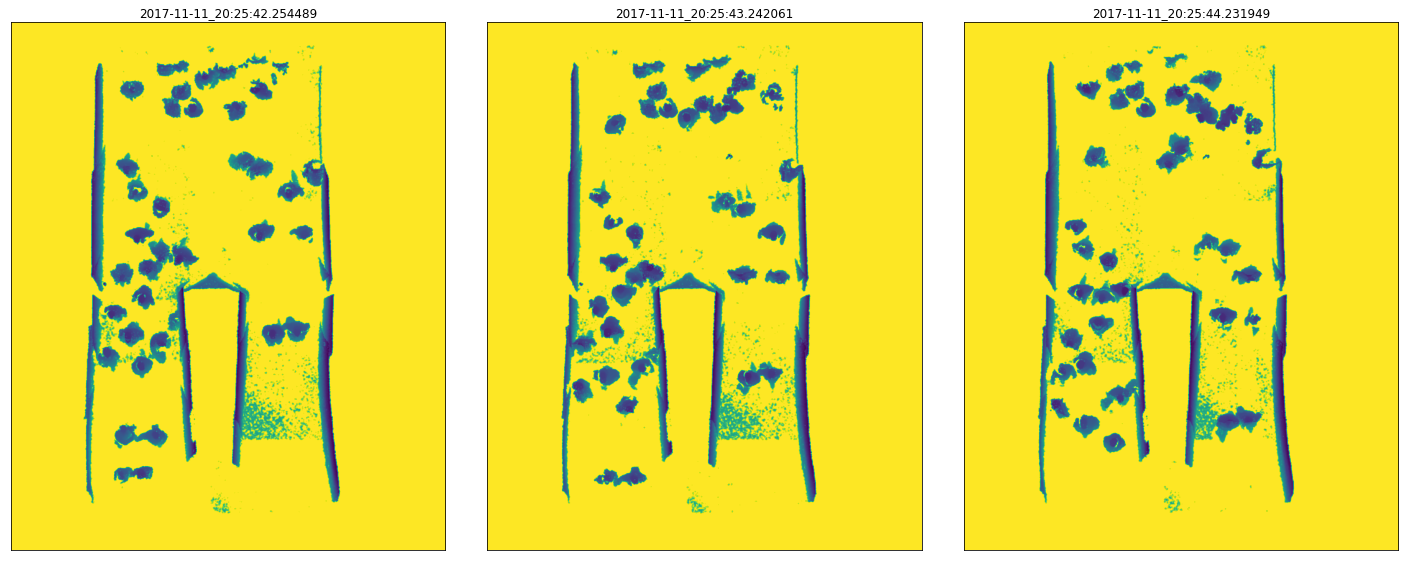

In [419]:
fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(20, 8))
fig.tight_layout()
frame= 0
for ax in axes:

    frame += 30 # one second later since we have 30 FPS data

    # plot depth map
    ax.imshow(depth_maps[frame])
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(time[frame])

## Make video

In many cases, making a video from the depth maps is useful. For instance, when we want to check if the trajectory data that follows from a localization algorithm is accurate and genuine. In other cases, the trajectory data that regards pedestrians as point particles might not be informative enough (e.g. when we are interested in shoulder orientation) or clear enough (e.g. when we want to see the time evolution of a trajectory as opposed to plotting the full trajectory at once). 

In [12]:
from matplotlib import animation
from IPython.display import HTML

N_start = 0 #start video from the 0th depth map
N_end = 500 #end video at the 500th depth map
skip = 1 #enables skipping frames to reduce render time

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8,10))
fig.tight_layout()

ims = []
# iterate over all frames
for i in np.arange(N_start, N_end)[::skip]:
    
    plt.xticks([]);     plt.yticks([])
    im = plt.imshow(depth_maps[i], animated=True)                  #plot depth map
    timestamp =  plt.text(50, 50, time[i], animated=True)   #plot timestamp 
    ims.append([im, timestamp])

# render animation
ani = animation.ArtistAnimation(fig, ims, interval=33*skip, blit=True)

plt.close("all")

# show animation
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

## Perform basic localization

The pedestrian detection algorithm is hereby concisely reported. The reader in need for more details is referred to https://www.sciencedirect.com/science/article/pii/S2352146514000490

### 1. Remove background

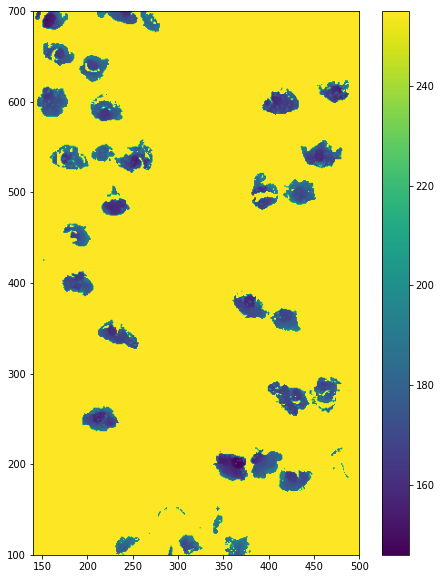

In [531]:
epsilon = 50
h = 60

# obtain background by averaging over first 500 depth maps
background = depth_maps[:500].mean(axis=0)

# remove background (may take some time..)
foreground = np.where(background  - depth_maps[:500] < epsilon, 0, background -  depth_maps[:500]).astype('uint8')

# the foreground is likely populated by elements which are not tall enough to 
# be pedestrians, therefore a second thresholding operation is performed.
foreground = 255 - np.where(foreground < h, 0, foreground)

# plot a depth map
plt.figure(0, figsize=(8,10))
plt.imshow(foreground[150])
plt.xlim([140, 500]); plt.ylim([100, 700])
plt.colorbar();

### 2. Foreground random sampling

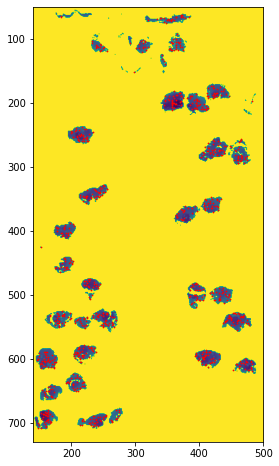

In [532]:
#lets start by localization on a single depth map..
single_depth_map = foreground[150]

def foreground_sampling(single_depth_map, N=1000):
    # compute indices of each pixel value
    vx = np.arange(single_depth_map.shape[1])
    vy = np.arange(single_depth_map.shape[0])
    idx_x, idx_y = np.meshgrid(vx, vy)

    # filter out all background pixel values
    idx_x = idx_x[single_depth_map != 255]
    idx_y = idx_y[single_depth_map != 255]

    # stack x and y indicices together
    samples = np.stack([idx_x, idx_y]).T

    # Shuffling the samples and taking first N samples
    np.random.shuffle(samples)
    samples = samples[:N]
    
    # retrieve sample coordinates in x, y and z
    xs = samples.T[0]
    ys = samples.T[1]
    zs = single_depth_map[ys, xs]
    
    return xs, ys, zs

xs, ys, zs = foreground_sampling(single_depth_map, N=1000)

# plot the samples on top of the foreground
plt.figure(0, figsize=(10,8))
plt.imshow(single_depth_map)
plt.scatter(xs, ys, color='red', s=0.5)
plt.xlim([140, 500]); plt.ylim([730, 50]);

### 3. Agglomerative clustering

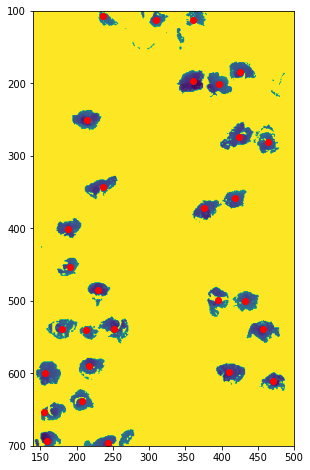

In [533]:
from scipy.cluster.hierarchy import fclusterdata

def agglomerative_clustering(x, y, z, body_size=150):
    
    # keep only samples that are not background (i.e. height higher than threshold 60)
    x_no_background = x[z > 60]
    y_no_background = y[z > 60]
    z_no_background = z[z > 60]
    
    # stack together x and y coordinates of these samples
    sampled_points = np.vstack([x_no_background, y_no_background]).T
    
    # compute clusters by agglomerative clustering algorithm 
    clusters = fclusterdata(sampled_points, body_size, criterion='distance', method='ward')
    
    # we convert to a pandas dataframe to compute mean position of each cluster
    # this dataframe will also be used for head identification 
    return pd.DataFrame({'cid':clusters, 'x':x_no_background, 'y':y_no_background, 'z':z_no_background})

# compute clusters of centroids
cluster_df = agglomerative_clustering(xs,ys,zs, body_size=150)

# compute mean position of each cluster
positions = cluster_df.groupby('cid').mean().values.T

# plot
plt.figure(figsize=(10, 8))
plt.imshow(single_depth_map)
plt.xlim([140, 500]); plt.ylim([700, 100])
plt.scatter(positions[0], positions[1], color='red') 
plt.show()

### 4. Head identification

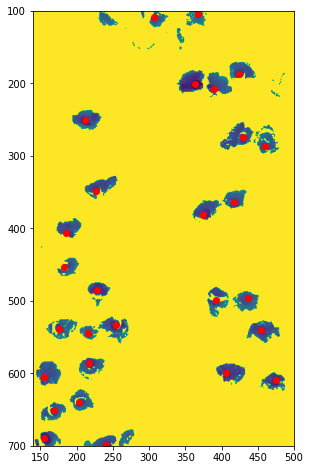

In [535]:
def identify_head(xs, ys, zs, percentile=10):
    
    # compute cutoff value by taking the 10th percentile
    cutoff = np.percentile(zs, q=percentile)
    
    # remove all samples not corresponding with the head
    xs = xs[zs <= cutoff]
    ys = ys[zs <= cutoff]
    
    # return the mean over these pixel positions
    return np.array([xs.mean(), ys.mean()])
    
# compute head positions
head_positions = cluster_df.groupby('cid').apply(lambda s : identify_head(s['x'], s['y'], s['z'], percentile=10)).values

# convert to pandas dataframe format again
head_positions = pd.DataFrame(np.stack(head_positions), columns=['x', 'y'])

# plot
plt.figure(figsize=(10, 8))
plt.imshow(single_depth_map)
plt.xlim([140, 500]); plt.ylim([700, 100])
plt.scatter(head_positions.x, head_positions.y, color='red') 
plt.show()

### Putting it all together..

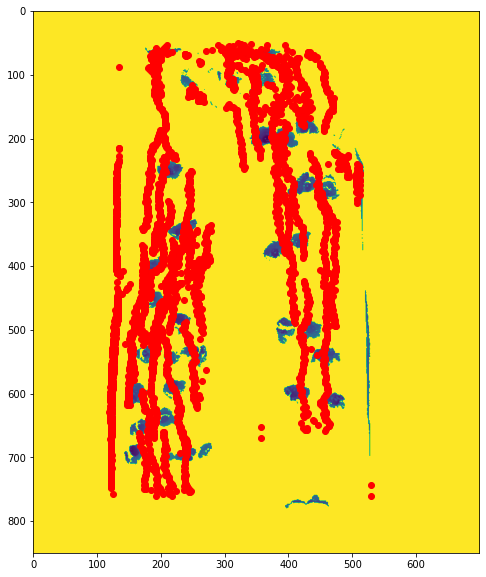

In [545]:
# remove background (for all depth maps!)
foreground = np.where(background  - depth_maps[:500] < epsilon, 0, background -  depth_maps[:500]).astype('uint8')

# the foreground is likely populated by elements which are not tall enough to 
# be pedestrians, therefore a second thresholding operation is performed.
foreground = 255-np.where(foreground < h, 0, foreground)

def track_positions_of_single_depth_map(single_depth_map, frame):
    
    # 2. foreground sampling
    xs, ys, zs = foreground_sampling(single_depth_map, N=2000)
    
    # 3. agglomeratove clustering, i.e. compute clusters of centroids
    cluster_df = agglomerative_clustering(xs, ys, zs, body_size=150)
    
    # compute head positions
    head_positions = cluster_df.groupby('cid').apply(lambda s : identify_head(s['x'], s['y'], s['z'], percentile=10)).values

    # convert to pandas dataframe format again
    head_positions = pd.DataFrame(np.stack(head_positions), columns=['x', 'y'])
    head_positions['frame'] = frame #add frame number 
    
    return head_positions


# perform tracking on all depth maps, concatenate results
head_positions = pd.concat([track_positions_of_single_depth_map(single_depth_map, frame) for frame, single_depth_map in enumerate(foreground[:100])])

In [565]:
import trackpy

max_vel = 1.5 #in m/s
pixel_conversion = 0.01680672269
FPS = 30
search_range = max_vel/(FPS*pixel_conversion)

In [567]:
tracks = trackpy.link_df(head_positions, search_range=search_range).copy()

Frame 99: 38 trajectories present.


KeyboardInterrupt: 

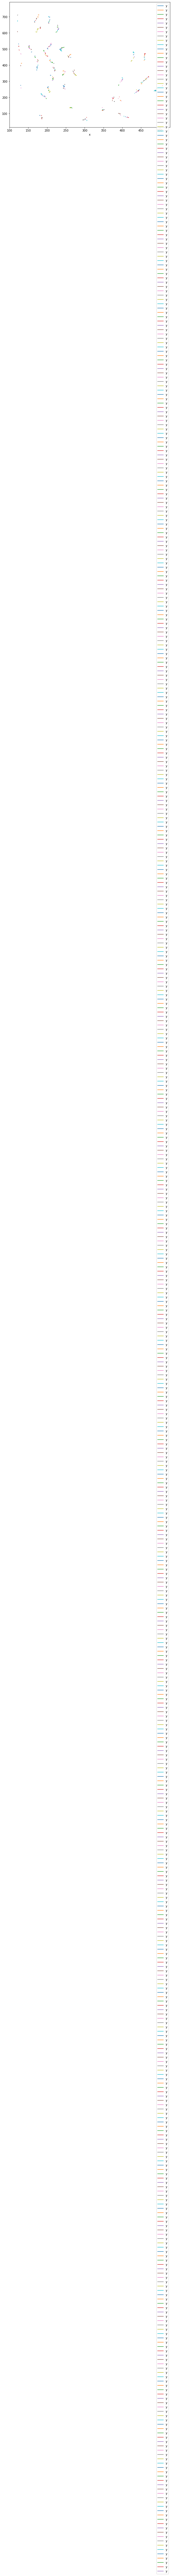

In [568]:
f, ax = plt.subplots(figsize=(10,8))
tracks.groupby('particle').plot('x', 'y', ax=ax)